The CSTR volume for a 0.711 conversion is 242.43548479030395
The PFR volume for a 0.711 conversion is 64.99397760721037


(array([ 49.65045381,  50.02168374,  50.39957326,  50.78429569,
         51.17603019,  51.5749621 ,  51.98128314,  52.39519169,
         52.81689312,  53.24660003,  53.6845326 ,  54.13091895,
         54.58599542,  55.050007  ,  55.5232077 ,  56.00586096,
         56.49824008,  57.00062868,  57.51332117,  58.03662329,
         58.5708526 ,  59.11633908,  59.67342574,  60.2424692 ,
         60.82384041,  61.41792536,  62.02512579,  62.64586004,
         63.28056386,  63.92969129,  64.59371568,  65.27313063,
         65.96845109,  66.68021452,  67.40898206,  68.15533988,
         68.91990052,  69.70330434,  70.50622113,  71.32935176,
         72.17342995,  73.03922422,  73.92753985,  74.83922115,
         75.77515373,  76.73626703,  77.72353699,  78.73798897,
         79.78070077,  80.85280603,  81.95549776,  83.0900322 ,
         84.25773298,  85.45999561,  86.69829227,  87.97417707,
         89.28929168,  90.64537145,  92.04425203,  93.48787657,
         94.97830349,  96.51771501,  98.

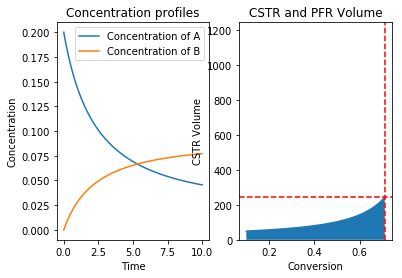

In [79]:
#!/usr/bin/env python
# coding: utf-8

# In[103]:


# Initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import fixed_quad
from scipy import integrate
from scipy.integrate import quad
from scipy.integrate import odeint
from sympy.solvers import solve
from sympy import Symbol
import math
from math import exp, expm1
from dataclasses import dataclass
from scipy.integrate import simps
from ipykernel import kernelapp
from scipy.integrate import dblquad
import numpy as np


#Define constants
Name = ["A", "B" ]
Concentration_initial = [0.2, 0]
Coefficient = [2, -1]
Order = np.abs(Coefficient)
Rate_constant_forward = 2
Rate_constant_reverse = Rate_constant_forward/100
Inflow_component = 5
Conversion = 0.711
Reversible = True


#Define the class
class reaction:
    def __init__(self, Name, Coefficient, Concentration_initial, Order, 
Rate_constant_forward, Rate_constant_reverse, Inflow_component, Conversion, Reversible = True):
        self.Name = Name 
        self.Coefficient = Coefficient  
        self.Concentration_initial = Concentration_initial
        self.Order = Order 
        self.Reversible = Reversible
        self.Rate_constant_forward = Rate_constant_forward
        self.Rate_constant_reverse = Rate_constant_reverse
        self.Inflow_component = Inflow_component
        self.Conversion = Conversion
        self.t_start = 0
        self.t_end = 10
        self.steps = (self.t_end - self.t_start)*24
    # Define the function that creates rate expressions  
    def reaction_function (self, C, t):

    # Find the coefficients of reactants and products:
        coef_reactants = list(filter(lambda Coefficient: Coefficient >0, Coefficient))
        coef_products = list(filter(lambda Coefficient: Coefficient <0, Coefficient))

        # Find the limiting reactant
        amounts = [];
        for i in range(0, len(coef_reactants)):
            amount = self.Concentration_initial[i]/self.Coefficient[i]
            amounts.append(amount);
        limit_amount = min(amounts)
        if limit_amount == amount:
            limit_coef = self.Coefficient[i]
            limit_conc = self.Concentration_initial[i]
       
        # Find the rate for the reversible     
        if self.Reversible == True:
            r_for = 1;
            r_reverse = 1;
            self.KC = self.Rate_constant_forward/self.Rate_constant_reverse
            n = len(Coefficient);
            r = np.zeros((n,1));
            
            for i in range(0,len(coef_reactants)): 
                r_f = C[i]**self.Order[i]
                r_for = r_f*r_for 
            
            for i in range(len(coef_reactants),len(Coefficient)):
                r_r = C[i]**self.Order[i]
                r_reverse = r_r*r_reverse
            
            rate = self.Rate_constant_forward*(r_for - r_reverse/self.KC)
            r[0,0] = rate;
            
            dCdt = [];
            for i in range(0,len(Coefficient)):
                r[i,0] = r[0,0]/limit_coef*self.Coefficient[i]
                dCdt.append(-r[i,0])
            
            
        # Find the rate for the irreversible 
        if self.Reversible == False:
            rate_for = 1;
            n = len(Coefficient);
            r = np.zeros((n,1));
            
            for i in range(len(coef_reactants)): 
                r_r = C[i]**self.Order[i]
                rate_for = r_r*rate_for
            rate = self.Rate_constant_forward*rate_for
            r[0,0] = rate;
            dCdt = [];
            for i in range(len(Coefficient)):
                r[i,0] = r[0,0]/limit_coef*self.Coefficient[i]
                dCdt.append(-r[i,0])
        
        return (dCdt)
    #solve the differential equiations to find the concentrationprofiles    
    def solve(self):
        t = np.linspace(self.t_start, self.t_end, self.steps)
        C = odeint(self.reaction_function, self.Concentration_initial ,t)
        #Make a plot of the concentrations
        for i in range(len(Name)):
            plt.figure
            plt.subplot(121)
            plt.plot(t, C[:,i],label = "Concentration of " + str(self.Name[i]))
            plt.title('Concentration profiles')
            plt.xlabel('Time')
            plt.ylabel('Concentration')
            plt.legend()
            plt.show
        
                
        return t, C
    
    #Find the reactor volumes
    def reactor_volume(self):
        #Define the reactant and product coefficients
        coef_reactants = list(filter(lambda Coefficient: Coefficient >0, Coefficient))
        coef_products = list(filter(lambda Coefficient: Coefficient <0, Coefficient))

        X = np.linspace(0.1, self.Conversion, 100)
        n = len(Coefficient)
        r = np.zeros((n,1))
        r_for = 1;
        r_reverse = 1;
        
        # Find the limiting reactant
        amounts = [];
        for i in range(0, len(coef_reactants)):
            amount = self.Concentration_initial[i]/self.Coefficient[i]
            amounts.append(amount);
        limit_amount = min(amounts)
        if limit_amount == amount:
            limit_coef = self.Coefficient[i]
            limit_conc = self.Concentration_initial[i]
        
        delta = 0;
        NT0 = 0;
        for i in range(0, len(Coefficient)):  
            d = (-1)*self.Coefficient[i]/limit_coef
            delta = d+delta
            N_T0 = self.Concentration_initial[i]
            NT0 = N_T0 + NT0
            epsilon=(delta*limit_conc/NT0)
        #epsilon = 0
        
        #Irreversible
        if self.Reversible == False:
            #Find rateexpressions for reversible reaction
            for i in range(0,len(coef_reactants)):
                rate_f = (limit_conc*((1-X)/(1+epsilon*X)))**self.Order[i]
                #rate_f = (self.Coefficient[i]*limit_amount*((1-X)/(1+epsilon*X)))**self.Order[i]
                r_for = r_for *rate_f
            
            rate = self.Rate_constant_forward * r_for
            #Define CSTR Volume for reversible reaction
            volume_CSTR = self.Inflow_component*self.Conversion/(rate)
            print('The CSTR volume for a ' + str(self.Conversion) + ' conversion is '  + str(volume_CSTR[-1]))
            
            
            #Find PFR volume for reversible reaction
            def integrand(X2):
               
                r_for = 1;
                r_reverse = 1;
                for i in range(0,1):
                    rate_f = (limit_conc*((1-X2)/(1+epsilon*X2)))**Order[i]
                    #rate_f = (self.Coefficient[i]*limit_amount*((1-X2)/(1+epsilon*X2)))**Order[i]
                    r_for = r_for *rate_f
            
                rate =  self.Rate_constant_forward * r_for 
                
                return self.Inflow_component/rate*self.Conversion
        
            Volume_PFR, err = quad(integrand, 0, self.Conversion)
            print('The PFR volume for a ' + str(self.Conversion) + ' conversion is '  + str(Volume_PFR))
            plt.figure
            plt.subplot(122)
            plt.plot(X, volume_CSTR,label = "CSTR volume")
            plt.ylim(0,volume_CSTR[-1]+1000)
            plt.xlabel('Conversion')
            plt.ylabel('CSTR Volume')
            plt.title('CSTR and PFR Volume')
            plt.fill_between(X,integrand(X))
            plt.axhline(y=volume_CSTR[-1], color='r', linestyle='--')
            plt.axvline(x=self.Conversion, color='r', linestyle='--')
        
        #Reversible    
        if self.Reversible == True:
            #Find rateexpressions for reversible reaction
            for i in range(0,len(coef_reactants)):
                rate_f = (self.Coefficient[i]*limit_amount*((1-X)/(1+epsilon*X)))**Order[i]
                r_for = r_for *rate_f
            
            for i in range(len(coef_reactants),len(Coefficient)):
                rate_reverse = (-self.Coefficient[i]*limit_amount*X)**self.Order[i]
                r_reverse = r_reverse * rate_reverse
            
            rate = self.Rate_constant_forward * (r_for  - r_reverse/self.KC)
            #Define CSTR Volume for reversible reaction
            volume_CSTR = self.Inflow_component*self.Conversion/(rate)
            print('The CSTR volume for a ' + str(self.Conversion) + ' conversion is '  + str(volume_CSTR[-1]))
            
            
            
            #Find PFR volume for reversible reaction
            def integrand(X2):
               
                r_for = 1;
                r_reverse = 1;
                for i in range(0,1):
                    rate_f = (self.Coefficient[i]*limit_amount*((1-X2)/(1+epsilon*X2)))**Order[i]
                    r_for = r_for *rate_f
            
                for i in range(1,2):
                    rate_reverse = (-self.Coefficient[i]*limit_amount*X2)**self.Order[i]
                    r_reverse = r_reverse * rate_reverse
            
                rate =  self.Rate_constant_forward * (r_for - r_reverse/self.KC);
                
                return self.Inflow_component/rate*self.Conversion
        
            Volume_PFR, err = quad(integrand, 0, self.Conversion)
            print('The PFR volume for a ' + str(self.Conversion) + ' conversion is '  + str(Volume_PFR))
            plt.figure
            plt.subplot(122)
            plt.plot(X, volume_CSTR,label = "CSTR volume")
            plt.ylim(0,volume_CSTR[-1]+1000)
            plt.xlabel('Conversion')
            plt.ylabel('CSTR Volume')
            plt.title('CSTR and PFR Volume')
            plt.fill_between(X,integrand(X))
            plt.axhline(y=volume_CSTR[-1], color='r', linestyle='--')
            plt.axvline(x=self.Conversion, color='r', linestyle='--')
          
        return volume_CSTR, Volume_PFR
        

reaction = reaction(Name, Coefficient, Concentration_initial, Order, 
                    Rate_constant_forward, Rate_constant_reverse, Inflow_component, Conversion,Reversible = True)

reaction.solve()
reaction.reactor_volume()


# In[ ]:





# In[ ]:




